In [1]:
import numpy as np
import pandas as pd
import utils

import copy, math, os, pickle, time 

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, GammaRegressor
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor


from sklearn.pipeline import Pipeline

from scipy.stats import pearsonr, spearmanr, kendalltau

# To show all columns in a dataframe
pd.options.display.max_info_columns=250
pd.options.display.max_columns=500

# To make pretty plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline

In [13]:
df_train = pd.read_csv("../data/eicu-ft46-S0-train.csv")
df_train.drop(columns=["starttime", "endtime"], inplace=True)

label = "log_duration"

print(df_train.shape)
df_train.head()

(16948, 54)


,stay_id,duration,over72h,ph_max,spo2_min,heart_rate_min,heart_rate_max,resp_rate_min,resp_rate_max,temp_min,temp_max,glucose_max,glucose_min,co2_total_max,co2_total_min,mbp_max,mbp_ni_min,apsiii,peep_max,peep_min,co2_total_avg,fio2_min,plateau_pressure_max,height,peep_avg,temp_avg,hr_score,mbp_score,temp_score,resp_rate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,SOFA,respiration,coagulation,liver,cardiovascular,cns,renal,hospitalid,numbedscategory,region,teachingstatus,log_duration
0,3112449,44.283,0,7.374,98.0,59.0,85.0,11.0,26.0,36.800,37.800,162.0,111.0,NaN,NaN,71.0,47.0,54.0,5.0,5.0,NaN,40.0,20.4,162.56,5.0,37.233,0.0,15.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,6.0,0.0,3.0,0.0,15.0,8,3,0,0,4,1,0,419,L,Northeast,False,3.790601
1,463995,94.183,1,7.352,93.0,62.0,120.0,18.0,30.0,36.700,37.000,NaN,NaN,NaN,NaN,107.0,52.0,74.0,5.0,5.0,NaN,35.0,30.0,167.60,5.0,36.883,0.0,15.0,0.0,6.0,0.0,3.0,19.0,3.0,5.0,0.0,3.0,0.0,0.0,8.0,0.0,48.0,9,3,0,0,1,4,1,144,M,South,False,4.545240
2,2449312,62.583,0,NaN,88.0,44.0,81.0,0.0,18.0,36.100,36.600,130.0,120.0,NaN,NaN,89.0,54.0,47.0,5.0,5.0,NaN,NaN,14.0,175.30,5.0,36.333,5.0,15.0,0.0,0.0,15.0,3.0,0.0,0.0,15.0,0.0,0.0,11.0,0.0,0.0,12.0,24.0,7,3,0,0,1,3,0,338,XL,Midwest,False,4.136494
3,3018787,43.867,0,NaN,93.0,59.0,123.0,16.0,35.0,36.611,38.222,144.0,68.0,NaN,NaN,97.5,52.0,47.0,NaN,NaN,NaN,NaN,NaN,170.20,NaN,37.615,7.0,15.0,2.0,9.0,0.0,3.0,0.0,0.0,15.0,0.0,2.0,11.0,0.0,0.0,2.0,0.0,4,3,0,0,1,0,0,417,L,South,False,3.781162
4,1591696,50.417,0,NaN,98.0,77.0,126.0,9.0,40.0,37.300,37.600,190.0,155.0,NaN,NaN,97.0,45.0,62.0,NaN,NaN,NaN,NaN,NaN,190.50,NaN,37.450,7.0,7.0,2.0,0.0,0.0,3.0,0.0,7.0,15.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,12,4,2,0,1,1,4,252,XL,Midwest,True,3.920328


In [14]:
hospid = df_train.hospitalid.value_counts().head(5).index

df_train = df_train[df_train.hospitalid==hospid[0]]
df_train.shape

(943, 54)

In [11]:
# df_train = df_train[(df_train.numbedscategory == "XL") | (df_train.numbedscategory == "L")]
df_train = df_train[df_train.numbedscategory == "L"].sample(3500)
df_train.shape

(3500, 54)

**Summary statistics**

In [4]:
df_train.describe()

,stay_id,duration,over72h,ph_max,spo2_min,heart_rate_min,heart_rate_max,resp_rate_min,resp_rate_max,temp_min,temp_max,glucose_max,glucose_min,co2_total_max,co2_total_min,mbp_max,mbp_ni_min,apsiii,peep_max,peep_min,co2_total_avg,fio2_min,plateau_pressure_max,height,peep_avg,temp_avg,hr_score,mbp_score,temp_score,resp_rate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,SOFA,respiration,coagulation,liver,cardiovascular,cns,renal,hospitalid,log_duration
count,9.430000e+02,943.000000,943.000000,588.000000,943.000000,943.000000,943.000000,942.000000,942.000000,943.000000,943.000000,943.000000,943.000000,588.000000,588.000000,943.000000,833.000000,842.000000,840.000000,840.000000,588.000000,562.000000,793.000000,942.000000,840.000000,943.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,821.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.0,943.000000
mean,3.084159e+06,159.708875,0.581124,7.366311,91.238600,73.562036,106.027572,12.928875,24.821656,36.294062,37.769777,179.414634,92.519618,24.642857,22.243197,99.059385,60.192077,66.820665,6.529167,5.542262,23.432600,51.832740,21.548424,169.810828,6.059745,37.068059,4.320862,11.547619,1.585034,4.482993,6.377551,2.846939,0.810658,2.078231,4.637188,4.933107,0.624717,5.662132,0.861678,1.231293,5.592971,19.356882,7.218452,3.252386,0.660657,0.342524,1.014846,1.015907,0.932131,420.0,4.615913
std,2.830781e+04,183.020765,0.493637,0.083415,9.695322,16.305995,20.919401,5.122955,5.685902,1.106421,0.910629,71.963727,21.170308,5.718406,6.203014,17.986480,12.514091,28.695911,2.767411,1.626380,5.718452,16.787456,5.471780,10.748367,2.087871,0.880645,4.359055,3.941470,4.331355,4.317197,7.100805,0.660493,2.529593,2.848741,4.599993,4.266525,0.987309,5.141065,2.927641,2.068305,5.270102,15.979729,3.012536,1.109662,0.955157,0.854838,0.770882,0.920838,1.238817,0.0,0.925981
min,3.033928e+06,24.067000,0.000000,7.000000,0.000000,28.000000,54.000000,0.000000,12.000000,30.100000,33.400000,80.000000,25.000000,13.000000,6.000000,60.000000,13.000000,-1.000000,0.000000,0.000000,12.000000,21.000000,11.000000,122.000000,0.000000,32.511000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,420.0,3.180842
25%,3.059743e+06,47.258500,0.000000,7.310000,90.000000,62.000000,92.000000,11.000000,21.000000,36.000000,37.300000,134.000000,79.500000,21.000000,18.000000,87.000000,52.000000,45.000000,5.000000,5.000000,19.750000,40.000000,17.000000,162.600000,5.000000,36.715500,0.000000,7.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,420.0,3.855633
50%,3.085816e+06,91.300000,1.000000,7.360000,93.000000,74.000000,104.000000,14.000000,24.000000,36.400000,37.800000,163.000000,93.000000,24.000000,22.000000,97.000000,60.000000,64.000000,5.000000,5.000000,22.550000,50.000000,21.000000,170.200000,5.000000,37.115000,5.000000,15.000000,0.000000,6.000000,2.000000,3.000000,0.000000,0.000000,4.000000,7.000000,0.000000,6.000000,0.000000,0.000000,3.000000,15.000000,7.000000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,420.0,4.514151
75%,3.108361e+06,200.375000,1.000000,7.420000,96.000000,84.000000,119.000000,16.000000,28.000000,36.900000,38.200000,200.000000,104.500000,27.000000,25.000000,108.000000,67.000000,85.000000,7.500000,5.000000,26.000000,60.000000,25.000000,177.800000,6.336250,37.550000,7.000000,15.000000,0.000000,7.000000,15.000000,3.000000,0.000000,4.000000,7.000000,7.000000,2.000000,11.000000,0.000000,3.000000,12.000000,33.000000,9.000000,4.000000,1.00

**Drop constant variables**

In [5]:
df_train = df_train.loc[:, df_train.apply(pd.Series.nunique) != 1]
df_train.shape

(943, 50)

### Feature selection

In [35]:
# features = ["apsiii",
#             "peep_min",
#             "gcs_score",
#             "acidbase_score",
#             "plateau_pressure_max",
#             "paraplegia",
#             "resp_rate_min",
#             "height",
#             "temp_max",
#             "co2_total_avg",
#             "fio2_min",
#             "cardiovascular",
#             "neuroblocker"]
# features = ["apsiii",
#             "peep_avg",
#             "gcs_score",
#             "acidbase_score",
#             "paraplegia",
#             "temp_max",
#             "height",
#             "resp_rate_min",
#             "SOFA",
#             "plateau_pressure_max",
#             "fio2_min",
#             "cardiovascular",
#             "neuroblocker",
#             "peep_min"]
# features = ['ph_max', 'spo2_min',
#             'heart_rate_min', 'heart_rate_max', 
#             'resp_rate_min', 'resp_rate_max',
#             'temp_min', 'temp_max', 
#             'glucose_max', 'glucose_min', 
#             'co2_total_max', 'co2_total_min', 
#             'mbp_max', 'mbp_ni_min', 
#             'apsiii', 
#             'peep_max', 'peep_min']
# MIMIC selected features
features = ["acidbase_score",
            "cns",
            "co2_total_avg",
            "gcs_score",
            "height",
#             "malignant_cancer",
#             "paraplegia",
            "peep_avg",
            "peep_min",
            "resp_rate_min",
            "temp_avg",
            "uo_score", 
#             "cluster",
           ]
# features = ['ph_max', 'spo2_min',
#             'heart_rate_min', 'heart_rate_max', 'resp_rate_min', 'resp_rate_max',
#             'temp_min', 'temp_max', 'glucose_max', 'glucose_min', 
#             'co2_total_max', 'co2_total_min', 'co2_total_avg', 
#             'mbp_max', 'mbp_ni_min', 'apsiii', 'peep_max',
#             'peep_min', 'fio2_min', 'plateau_pressure_max',
#             'height', 'peep_avg', 'temp_avg', 'hr_score', 'mbp_score', 'temp_score',
#             'resp_rate_score', 'pao2_aado2_score', 'hematocrit_score', 'wbc_score',
#             'creatinine_score', 'uo_score', 'bun_score', 'sodium_score',
#             'albumin_score', 'bilirubin_score', 'glucose_score', 'acidbase_score',
#             'gcs_score', 'SOFA', 'respiration', 'coagulation', 'liver',
#             'cardiovascular', 'cns', 'renal']
# # All eICU features
# features = ['ph_max', 'spo2_min',
#        'heart_rate_min', 'heart_rate_max', 'resp_rate_min', 'resp_rate_max',
#        'temp_min', 'temp_max', 'glucose_max', 'glucose_min', 'co2_total_max',
#        'co2_total_min', 'mbp_max', 'mbp_ni_min', 'apsiii', 'peep_max',
#        'peep_min', 'co2_total_avg', 'fio2_min', 'plateau_pressure_max',
#        'height', 'peep_avg', 'temp_avg', 'hr_score', 'mbp_score', 'temp_score',
#        'resp_rate_score', 'pao2_aado2_score', 'hematocrit_score', 'wbc_score',
#        'creatinine_score', 'uo_score', 'bun_score', 'sodium_score',
#        'albumin_score', 'bilirubin_score', 'glucose_score', 'acidbase_score',
#        'gcs_score', 'SOFA', 'respiration', 'coagulation', 'liver',
#        'cardiovascular', 'cns', 'renal', 
# #             'hospitalid', 'region', 'teachingstatus',
# #             'numbedscategory',
#            ]

# Selected 19 features
# features = ['peep_max', 'plateau_pressure_max', 'resp_rate_score', 
#             'temp_avg', 'fio2_min', 'apsiii', 'ph_max', 'acidbase_score', 'glucose_min',
#             'co2_total_min', 'respiration', 'heart_rate_max', 'resp_rate_min', 'spo2_min',
#             'albumin_score', 'gcs_score', 'cardiovascular', 'mbp_ni_min', 'wbc_score']

X_train, y_train = utils.get_X_and_y(df_train, features=features, label=label)
print(X_train.shape, y_train.shape)

preprocessor = utils.define_preprocessor(X_train.columns)

(943, 10) (943,)


### Model development

In [36]:
regs = (
    LinearRegression(),
#     Ridge(),
#     Lasso(),
#     ElasticNet(),
#     GammaRegressor(),
#     LinearSVR(),
#     GaussianProcessRegressor(),
#     DecisionTreeRegressor(),
    RandomForestRegressor(),
#     ExtraTreesRegressor(),
    GradientBoostingRegressor(),
#     XGBRegressor(),
)

for reg in regs:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', reg)])
    scores = utils.benchmark_cv_score(pipe, X_train, y_train, head="reg")

________________________________________________________________________________

Model training: 
LinearRegression()
train time: 0.082s

Average RMSE: 0.890 (+/- 0.13)
Average Pearson: 0.280 (+/- 0.29)
Average Spearman: 0.308 (+/- 0.30)
________________________________________________________________________________

Model training: 
RandomForestRegressor()
train time: 1.901s

Average RMSE: 0.903 (+/- 0.15)
Average Pearson: 0.287 (+/- 0.22)
Average Spearman: 0.300 (+/- 0.22)
________________________________________________________________________________

Model training: 
GradientBoostingRegressor()
train time: 0.632s

Average RMSE: 0.892 (+/- 0.14)
Average Pearson: 0.308 (+/- 0.19)
Average Spearman: 0.333 (+/- 0.19)


### Evaluate the model

In [39]:
preprocessor = utils.define_preprocessor(X_train.columns)
reg = GradientBoostingRegressor()
# reg = RandomForestRegressor()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', reg)])
df_train["y_pred"] = utils.benchmark_cv(pipe, X_train, y_train, head="reg")

________________________________________________________________________________

Model training: 
train time: 0.671s


In [40]:
pearsonr(df_train.log_duration, df_train.y_pred)[0]

0.3026228113818834

In [ ]:
y_train.mean(), y_train.std(), y_train.min(), y_train.max()

In [ ]:
df_train.y_pred.mean(), df_train.y_pred.std(), df_train.y_pred.min(), df_train.y_pred.max()

In [ ]:
palette = sns.color_palette("Set2", 4)
sns.lineplot(x=[3,8], y=[3,7], linestyle="--");
sns.scatterplot(x="log_duration", y="y_pred", hue="cluster", data=df_train, 
                palette=palette, alpha=0.8);
plt.xlabel("Observed log(duration)");
plt.ylabel("Predicted log(duration)");

In [ ]:
sns.lmplot(x="log_duration", y="y_pred", col="cluster", data=df_train);

In [ ]:
for i in df_train.cluster.unique():
    print("For cluster %d, Pearson's rho = %.2f" % 
          (i, pearsonr(df_train[df_train.cluster == i].log_duration, df_train[df_train.cluster == i].y_pred)[0]))

In [ ]:
df_train["residual"] = df_train.log_duration - df_train.y_pred
df_train["std_residual"] = (df_train.residual - df_train.residual.mean()) / df_train.residual.std()

In [ ]:
sns.lineplot(x=[3,6], y=[0,0], linestyle="--", color="r");
sns.scatterplot(x="y_pred", y="std_residual", data=df_train, alpha=0.3);

# Evaluate on the test set

In [31]:
df_test = pd.read_csv("../data/eicu-ft46-S0-test.csv")
df_test.drop(columns=["starttime", "endtime"], inplace=True)
print(df_test.shape)
df_test.head()

(4237, 54)


,stay_id,duration,over72h,ph_max,spo2_min,heart_rate_min,heart_rate_max,resp_rate_min,resp_rate_max,temp_min,temp_max,glucose_max,glucose_min,co2_total_max,co2_total_min,mbp_max,mbp_ni_min,apsiii,peep_max,peep_min,co2_total_avg,fio2_min,plateau_pressure_max,height,peep_avg,temp_avg,hr_score,mbp_score,temp_score,resp_rate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,SOFA,respiration,coagulation,liver,cardiovascular,cns,renal,hospitalid,numbedscategory,region,teachingstatus,log_duration
0,3053860,70.700,0,7.26,91.0,94.0,134.0,16.0,29.0,37.900,38.800,211.0,81.0,16.0,15.0,86.0,38.0,142.0,7.5,5.0,15.25,60.0,28.0,165.1,6.786,38.277,7.0,15.0,0.0,6.0,0.0,3.0,1.0,7.0,15.0,11.0,2.0,0.0,0.0,3.0,12.0,48.0,14,4,0,1,1,4,4,420,XL,Northeast,True,4.258446
1,1634912,97.917,1,7.29,89.0,67.0,106.0,15.0,32.0,36.380,37.270,249.0,147.0,29.5,29.5,78.0,40.0,67.0,8.0,8.0,29.50,50.0,32.0,165.0,8.000,36.882,5.0,15.0,0.0,6.0,0.0,3.0,1.0,0.0,15.0,7.0,0.0,11.0,0.0,5.0,1.0,15.0,7,4,0,0,1,2,0,264,XL,Midwest,True,4.584120
2,3098349,293.067,1,NaN,94.0,79.0,107.0,14.0,24.0,36.200,37.900,202.0,67.0,NaN,NaN,159.0,59.0,83.0,5.0,5.0,NaN,NaN,16.0,157.5,5.000,37.129,5.0,10.0,0.0,0.0,15.0,3.0,0.0,7.0,5.0,11.0,0.0,6.0,0.0,3.0,12.0,33.0,7,3,0,0,1,1,2,420,XL,Northeast,True,5.680401
3,1211069,164.317,1,7.38,89.0,61.0,82.0,16.0,18.0,36.900,37.500,109.0,81.0,NaN,NaN,87.5,53.0,91.0,5.0,5.0,NaN,40.0,NaN,175.0,5.000,37.267,0.0,15.0,2.0,0.0,15.0,3.0,0.0,7.0,5.0,11.0,2.0,11.0,0.0,0.0,0.0,15.0,7,2,0,0,1,2,2,208,XL,South,False,5.101797
4,267571,46.433,0,7.40,95.0,64.0,88.0,14.0,36.0,36.225,37.003,146.0,146.0,NaN,NaN,95.0,69.0,69.0,5.0,5.0,NaN,40.0,NaN,162.6,5.000,36.614,0.0,7.0,0.0,9.0,0.0,3.0,19.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,5,2,0,0,1,2,0,79,XL,Midwest,False,3.838010


In [ ]:
# df_test = df_test[df_test.numbedscategory == "XL"]
# df_test.numbedscategory.value_counts()

In [32]:
X_test, y_test = utils.get_X_and_y(df_test, features=features, label=label)
print(X_test.shape, y_test.shape)

(4237, 50) (4237,)


In [33]:
preprocessor = utils.define_preprocessor(X_train.columns)
reg = GradientBoostingRegressor()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', reg)])

In [34]:
pipe.fit(X_train, y_train)
df_test["y_pred"] = pipe.predict(X_test)

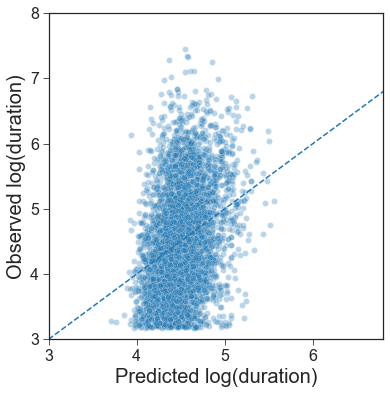

In [35]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.lineplot(x=[3,8], y=[3,8], linestyle="--");
sns.scatterplot(y="log_duration", x="y_pred", data=df_test, alpha=0.3);
plt.ylabel("Observed log(duration)");
plt.xlabel("Predicted log(duration)");
plt.xlim([3,6.8]);
plt.ylim([3,8]);
plt.savefig('../results/reg train on eicu test on eicu 46ft.jpeg', bbox_inches='tight', dpi=300)

In [ ]:
pearsonr(df_test.log_duration, df_test.y_pred)[0]

In [ ]:
pearsonr(df_test[df_test.numbedscategory=="XL"].log_duration, df_test[df_test.numbedscategory=="XL"].y_pred)[0]

In [ ]:
pearsonr(df_test[df_test.numbedscategory=="L"].log_duration, df_test[df_test.numbedscategory=="L"].y_pred)[0]

In [ ]:
pearsonr(df_test[df_test.numbedscategory=="M"].log_duration, df_test[df_test.numbedscategory=="M"].y_pred)[0]

In [ ]:
pearsonr(df_test[df_test.numbedscategory=="S"].log_duration, df_test[df_test.numbedscategory=="S"].y_pred)[0]

# Validate on MIMIC

In [7]:
df_mimic = pd.read_csv("../data/mimic-ft98.csv")
df_mimic.drop(columns=["starttime", "endtime"], inplace=True)

print(df_mimic.shape)
df_mimic.head()

(12652, 103)


,stay_id,admission_location,insurance,language,ethnicity,marital_status,gender,age,hours_in_hosp_before_intubation,weight,height,co2_total_max,co2_total_avg,co2_total_min,ph_max,ph_avg,ph_min,lactate_max,lactate_avg,lactate_min,pao2fio2ratio,heart_rate_max,heart_rate_avg,heart_rate_min,mbp_max,mbp_avg,mbp_min,mbp_ni_max,mbp_ni_avg,mbp_ni_min,resp_rate_max,resp_rate_avg,resp_rate_min,temp_max,temp_avg,temp_min,spo2_max,spo2_avg,spo2_min,glucose_max,glucose_avg,glucose_min,vasopressin,epinephrine,dobutamine,norepinephrine,phenylephrine,dopamine,count_of_vaso,fio2_max,fio2_avg,fio2_min,peep_max,peep_avg,peep_min,plateau_pressure_max,plateau_pressure_avg,plateau_pressure_min,rrt,sinus_rhythm,neuroblocker,congestive_heart_failure,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,SOFA,respiration,coagulation,liver,cardiovascular,cns,renal,apsiii,hr_score,mbp_score,temp_score,resp_rate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,duration,log_duration,over72h,alive96h
0,30000670,EMERGENCY ROOM,Medicare,ENGLISH,BLACK/AFRICAN AMERICAN,DIVORCED,M,69,81,51.7,173.0,38.0,37.000000,36.0,7.39,7.390000,7.39,2.2,2.200000,2.2,305.0,83.0,67.520000,56.0,95.0,79.880000,68.0,95.0,79.88,68.0,20.5,15.442308,13.0,36.61,35.787500,35.00,100.0,99.923077,98.0,179.0,165.500000,149.0,0,0,0,0,0,0,0,50.0,41.111111,40.0,6.4,4.640000,0.0,18.0,14.200000,11.0,0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4,2.0,0.0,NaN,0.0,1,1.0,47,1.0,7.0,2.0,8.0,0.0,3.0,0.0,0.0,7.0,7.0,0.0,NaN,NaN,0.0,12.0,0.0,26.250000,3.267666,0,1
1,30000974,EMERGENCY ROOM,Medicare,ENGLISH,WHITE,SINGLE,F,92,0,55.0,157.0,25.0,25.000000,25.0,7.44,7.440000,7.44,2.4,2.400000,2.4,252.0,91.0,82.500000,69.0,78.0,66.478261,52.0,53.0,52.50,52.0,34.0,29.108696,20.0,38.22,37.406667,37.00,100.0,98.318182,97.0,159.0,130.500000,102.0,0,0,0,1,0,0,1,50.0,50.000000,50.0,5.0,5.000000,5.0,17.0,15.500000,14.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0.0,0.0,0.0,3.0,3,0.0,76,0.0,15.0,0.0,6.0,0.0,3.0,5.0,0.0,5.0,11.0,0.0,6.0,0.0,0.0,12.0,13.0,377.666667,5.934012,1,1
2,30001939,EMERGENCY ROOM,Medicaid,ENGLISH,WHITE,SINGLE,M,47,460,42.0,175.0,20.0,19.142857,18.0,7.28,7.224286,7.18,1.3,1.250000,1.2,92.5,108.0,87.821429,62.0,98.0,76.431034,58.0,98.0,78.15,57.0,34.0,21.550000,14.0,36.67,36.325000,35.89,100.0,96.964286,92.0,158.0,112.400000,91.0,0,0,0,1,0,0,1,100.0,88.333333,80.0,7.0,4.454545,0.0,31.0,31.000000,31.0,0,1.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,13,4.0,1.0,0.0,4.0,4,0.0,132,1.0,15.0,2.0,9.0,14.0,3.0,5.0,3.0,5.0,2.0,2.0,11.0,0.0,0.0,12.0,48.0,214.750000,5.369475,1,1
3,30002055,WALK-IN/SELF REFERRAL,Medicare,ENGLISH,BLACK/AFRICAN AMERICAN,MARRIED,M,69,2,58.8,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,116.500000,90.0,150.0,83.250000,44.0,65.0,53.25,44.0,26.0,19.580000,10.0,35.00,33.950000,33.20,100.0,99.190476,84.0,271.0,229.111111,167.0,0,1,0,1,0,0,2,30.0,30.000000,30.0,19.0,11.933333,8.0,30.0,23.833333,18.0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,NaN,4.0,1,0.0,62,7.0,10.0,20.0,0.0,15.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,2.0,0.0,66.450000,4.196450,0,1
4,30003299,EMERGENCY ROOM,Other,ENGLISH,WHITE,SINGLE,M,26,1,120.0,178.0,29.0,24.888889,21.0,7.40,7.335556,7.27,4.0,2.777778,1.5,280.0,133.0,119.500000,101.0,122.0,93.071429,70.0,NaN,NaN,NaN,18.0,17.105263,12.0,37.44,36.971667,36.39,100.0,98.555556,96.0,185.0,152.166667,130.0,0,0,0,0,0,0,0,50.0,48.333333,40.0,5.0,5.000000,5.0,25.0,23.600000,22.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.0,0.0,NaN,0.0,3,0.0,48,7.0,7.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,0.0,12.0,15.0,154.183333,5.038142,1,1


In [8]:
X_mimic, y_mimic = utils.get_X_and_y(df_mimic, features=features, label=label)
print(X_mimic.shape, y_mimic.shape)

(12652, 46) (12652,)


In [9]:
preprocessor = utils.define_preprocessor(X_train.columns)
reg = GradientBoostingRegressor()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', reg)])

In [10]:
pipe.fit(X_train, y_train)
df_mimic["y_pred"] = pipe.predict(X_mimic)

In [11]:
pearsonr(df_mimic.log_duration, df_mimic.y_pred)[0]

0.24769049134458476

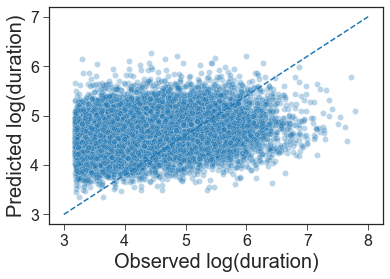

In [12]:
sns.lineplot(x=[3,8], y=[3,7], linestyle="--");
sns.scatterplot(x="log_duration", y="y_pred", data=df_mimic, alpha=0.3);
plt.xlabel("Observed log(duration)");
plt.ylabel("Predicted log(duration)");

In [ ]:
y_eicu.mean(), y_eicu.std(), y_eicu.min(), y_eicu.max()

In [ ]:
df_eicu.y_pred.mean(), df_eicu.y_pred.std(), df_eicu.y_pred.min(), df_eicu.y_pred.max()